# LLNL WPS Client

This tutorial will demonstrate the features of the LLNL WPS Client.

**Prerequisites**
- Environment
  - `conda create -n cwt -c conda-forge -c cdat esgf-compute-api cdms2 matplotlib cartopy ipykernel`
- Expose conda kernel
  - `conda activate cwt; python -m ipykernel install --user --name cwt`

**Features**
- LLNLAuthenticator handles authentication and token retrieval.
  - Can store token in between sessions.
- LLNLClient provides access to job management.

First we'll run a little setup then move onto looking at [authentication](#Authentication).

In [1]:
import os
import owslib
import cwt
from cwt import llnl_client

server_url = os.environ.get('SERVER_URL', 'https://aims2.llnl.gov/')
verify = bool(os.environ.get('VERIFY', True))
wps_url = os.environ.get('WPS_URL', 'https://aims2.llnl.gov/wps')

## Authentication

By default 3 authenticators are offered.

* [OWSLib authentication](#OWSLib-authentication)
* [LLNL authentication](#LLNL-authentication)
* [Token Authenticator](#Token-authentication) 

### OWSLib authentication

This method provides access to secure WPS servers requiring basic authentication or certificates.

In [2]:
auth = owslib.util.Authentication(username='test', password='test')
auth

<Authentication shared=False username=test password=test cert=None verify=True>

### LLNL authentication

This method utilizes the LLNL compute authentication which uses ESGF OpenID service.

In [3]:
auth = llnl_client.LLNLAuthenticator(server_url=server_url)
auth

LLNLAuthenticator(server_url='https://aims2.llnl.gov/', openid_url='https://esgf-node.llnl.gov/esgf-idp/openid', verify=True)

### Token authentication

This method uses and existing token to that will be passed in the header as `Authorization: Bearer <token>`.

In [4]:
auth = llnl_client.TokenAuthenticator('token')
auth

# LLNL WPS Client

The `LLNLAuthenticator` is token based. It handles redirecting the user for login and retrieving their token.

The `LLNLClient` is an extension of the standard `WPSClient`. It provides extended support such as job history/management.

Below we'll initialize the client and take a look at the process offerrings.

In [5]:
auth = llnl_client.LLNLAuthenticator(server_url, store=True)

client = llnl_client.LLNLClient(wps_url, auth=auth)
client

CDAT.workflow,CDAT.workflow,devel,None,None,Holds the ouputs to a complex workflow. Each input represents a unique output. Domain and parameters defined in the workflow process will act like defaults for each child process. Accepts a minimum of 1 inputs.
CDAT.abs,CDAT.abs,devel,None,None,"Computes elementwise absolute on each variable. Can be applied to a single variable if the parameter `variable` is used. Accepts exactly 1 input. Parameters: variable (str): Target variable for the process. rename (list): List of pairs mapping variable to new name e.g. pr,pr_test will rename pr to pr_test. fillna (float): The number used to replace nan values in output."
CDAT.add,CDAT.add,devel,None,None,"Computes an elementwise sum for each variable between an input or constant. Can be applied to a single variable if the parameter `variable` is used. Accepts 1 to 2 inputs. Parameters: variable (str): Target variable for the process. rename (list): List of pairs mapping variable to new name e.g. pr,pr_test will rename pr to pr_test. fillna (float): The number used to replace nan values in output. const (float): A value that will be applied element-wise."
CDAT.aggregate,CDAT.aggregate,devel,None,None,"Aggregates a variable spanning multiple input files. Accepts a minimum of 2 inputs. Parameters: rename (list): List of pairs mapping variable to new name e.g. pr,pr_test will rename pr to pr_test. fillna (float): The number used to replace nan values in output."
CDAT.divide,CDAT.divide,devel,None,None,"Compute elementwise division between a variable or constant. Can be applied to a single variable if the parameter `variable` is used. Accepts 1 to 2 inputs. Parameters: variable (str): Target variable for the process. rename (list): List of pairs mapping variable to new name e.g. pr,pr_test will rename pr to pr_test. fillna (float): The number used to replace nan values in output. const (float): A value that will be applied element-wise."
CDAT.exp,CDAT.exp,devel,None,None,"Computes elementwise exponent on each variable. Can be applied to a single variable if the parameter `variable` is used. Accepts exactly 1 input. Parameters: variable (str): Target variable for the process. rename (list): List of pairs mapping variable to new name e.g. pr,pr_test will rename pr to pr_test. fillna (float): The number used to replace nan values in output."
CDAT.filter_map,CDAT.filter_map,devel,None,None,"Applies a filter and function to a variable defined using the `variable` parameter. See `CDAT.where` abstract for details on supported conditions. Accepts exactly 1 input. Parameters: variable (str): Target variable for the process. rename (list): List of pairs mapping variable to new name e.g. pr,pr_test will rename pr to pr_test. func (str): A reduction process to apply e.g. max, min, sum, mean. fillna (float): The number used to replace nan values in output. cond (str): A condition that when true will preserve the value. other (float): A value that will be used when `cond` is false."
CDAT.log,CDAT.log,devel,None,None,"Computes the elementwise log for each variable. Can be applied to a single variable if the parameter `variable` is used. Accepts exactly 1 input. Parameters: variable (str): Target variable for the process. rename (list): List of pairs mapping variable to new name e.g. pr,pr_test will rename pr to pr_test. fillna (float): The number used to replace nan values in output."
CDAT.max,CDAT.max,devel,None,None,"Computes the maximum for each variable over one or more axes. Can be applied to a single variable if the parameter `variable` is used. Accepts exactly 1 input. Parameters: variable (str): Target variable for the process. rename (list): List of pairs mapping variable to new name e.g. pr,pr_test will rename pr to pr_test. fillna (float): The number used to replace nan values in output. axes (list): A list of axes used to reduce dimensionality."
CDAT.mean,CDAT.mean,devel,None,None,"Computes the mean for each variable over one or more axes. Can be app

# Creating inputs and domains

Next we'll create a single input consisting of an single OpeNDAP file and a domain which subsets along the `time` and `lat` axes.

In [6]:
inputs = cwt.Variable('http://aims3.llnl.gov/thredds/dodsC/css03_data/CMIP6/CMIP/NASA-GISS/GISS-E2-1-G/historical/r10i1p1f1/Amon/tas/gn/v20180830/tas_Amon_GISS-E2-1-G_historical_r10i1p1f1_gn_190101-195012.nc', 'tas')

In [7]:
subset = client.CDAT.subset(inputs, domain=cwt.Domain(time=('1910', '1925'), lat=(0, 90)))
subset

Process(name=9173f0c6, identifier=CDAT.subset, inputs=[Variable(name='1cebf986', uri='http://aims3.llnl.gov/thredds/dodsC/css03_data/CMIP6/CMIP/NASA-GISS/GISS-E2-1-G/historical/r10i1p1f1/Amon/tas/gn/v20180830/tas_Amon_GISS-E2-1-G_historical_r10i1p1f1_gn_190101-195012.nc', var_name='tas', domain=None, mime_type=None)], parameters={}, domain=Domain(Dimension(name='time', start='1910', end='1925', step=1, crs=CRS(name='timestamps')), Dimension(name='lat', start=0, end=90, step=1, crs=CRS(name='values')), mask=None, name='d30eb4c9'), title=CDAT.subset, process_outputs=[], data_inputs=[], status_supported=None, store_supported=None, process_version=devel)

# Execute the process server-side

Here we'll request to execute the process and wait on it's output.

In [8]:
client.execute(subset)

subset.wait()

ProcessAccepted None
ProcessStarted Building output for '6806d2dc' - 'CDAT.subset' 0.0
ProcessStarted Processing 55.0
ProcessStarted Processing 100.0
ProcessSucceeded


True

# Job History

Using the `LLNLClient` we're provided access to our job history.

This defaults to 10 entries per page. You can navigate the pages using `jobs.previous()` and `jobs.next()` calls.

In [9]:
jobs = client.jobs()

# next page of jobs
jobs.next()

# previous page of jobs
jobs.previous()

jobs

ID,Operation,Elapsed,Status,Accepted
1,CDAT.subset,55.308534,ProcessSucceeded,2020-09-14T22:58:55.547767+00:00
2,CDAT.subset,54.216669,ProcessSucceeded,2020-09-15T16:23:06.624776+00:00
3,CDAT.subset,53.153557,ProcessSucceeded,2020-09-16T16:09:56.525962+00:00
4,CDAT.subset,53.74164,ProcessSucceeded,2020-09-17T09:38:26.195375+00:00
5,CDAT.subset,53.390830,ProcessSucceeded,2020-09-17T15:15:41.396644+00:00
6,CDAT.subset,49.65060,ProcessSucceeded,2020-09-17T15:17:36.775099+00:00
7,CDAT.subset,53.198471,ProcessSucceeded,2020-09-17T15:39:21.502035+00:00
8,CDAT.subset,101.212967,ProcessSucceeded,2020-09-17T15:39:51.714120+00:00
9,CDAT.subset,101.295139,ProcessSucceeded,2020-09-17T15:40:08.189755+00:00
10,CDAT.subset,50.280597,ProcessSucceeded,2020-09-17T15:42:57.661258+00:00


## You can view the specifics of a job

Using the ID column from the job listing you can view the details of a job.

In [11]:
jobs[1]

Status,Created,Output
ProcessAccepted,2020-09-14T15:58:55.547767-07:00,2020-09-14T15:58:56.076009-07:00 Validating inputs and parameters of CDAT.subset (71eae287) 0.0
,,2020-09-14T15:58:56.037298-07:00 Validating workflow 0.0
ProcessStarted,2020-09-14T15:58:56.233728-07:00,2020-09-14T15:58:56.641166-07:00 Preparing inputs for process CDAT.subset (71eae287) 0.0
,,2020-09-14T15:58:57.143426-07:00 Gathered 1 inputs for process CDAT.subset (71eae287) 0.0
,,2020-09-14T15:58:57.184960-07:00 Building process CDAT.subset (71eae287) 0.0
,,"2020-09-14T15:58:57.248382-07:00 Subset dimension time (600,) -> (192,) 0.0"
,,"2020-09-14T15:58:57.294150-07:00 Subset dimension lat (90,) -> (45,) 0.0"
,,2020-09-14T15:58:57.350037-07:00 Preparing to execute workflow 0.0
,,2020-09-14T15:59:00.146332-07:00 Building output for '71eae287' - 'CDAT.subset' 0.0
,,2020-09-14T15:59:20.092499-07:00 Setting output filename CDAT.subset_71eae287_99a5543c_1910-1925.nc 0.0


# Plotting the results

In [12]:
import cdms2
import cartopy.crs as ccrs
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
from matplotlib import pyplot as plt

In [13]:
with cdms2.open(subset.output.uri) as f:
    data = f('tas', time=0, squeeze=1)

/home/jovyan/conda-envs/cwt/lib/python3.7/site-packages/cdms2/tvariable.py:281: DeprecationWarning: Non-scalar arrays for the fill value are deprecated. Use arrays with scalar values instead. The filled function still supports any array as `fill_value`.
  self._missing = numpy.array(value).astype(self.dtype)


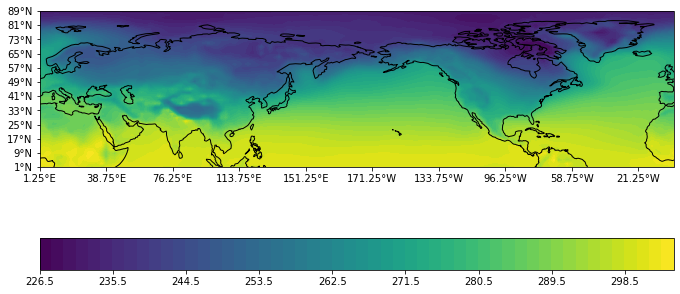

In [14]:
%matplotlib inline

fig = plt.figure(figsize=(25, 40))

ax1 = plt.subplot(4, 2, 1, projection=ccrs.PlateCarree(central_longitude=180))
ax1.coastlines()
im1 = ax1.contourf(data.getLongitude(), data.getLatitude(), data, 60, transform=ccrs.PlateCarree())
ax1.set_xticks(data.getLongitude()[::15], crs=ccrs.PlateCarree())
ax1.set_yticks(data.getLatitude()[::4], crs=ccrs.PlateCarree())

ax1.xaxis.set_major_formatter(LongitudeFormatter())
ax1.yaxis.set_major_formatter(LatitudeFormatter())

plt.colorbar(im1, orientation='horizontal')